In [6]:
import os
import tensorflow as tf

2022-10-07 19:54:51.730674: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:

data_directory = os.getcwd().rsplit("/", 1)[0] + "/data/224x224_currency"
print(data_directory)


/Users/ujjwal/Documents/data/224x224_currency


In [14]:
model_dir = os.getcwd() + "/experiments/smaller_model/4_ConvBlock"
data_dir = os.getcwd().rsplit("/", 1)[0] + "/data/224x224_currency"

In [15]:
from model.utils import Params

In [16]:
tf.random.set_seed(230)
json_path = os.path.join(model_dir, "params.json")
assert os.path.isfile(json_path), "No json configuration file found at {}".format(json_path)
params = Params(json_path)
params

In [17]:
train_data_dir = os.path.join(data_dir, "train_dir")
dev_data_dir = os.path.join(data_dir, "dev_dir")

In [120]:
train_filenames = [os.path.join(train_data_dir, f) for f in os.listdir(train_data_dir) if f.endswith(".jpg")]
eval_filenames = [os.path.join(dev_data_dir, f) for f in os.listdir(dev_data_dir) if f.endswith(".jpg")]

    # Labels will be between 0 and 5 included (6 classes in total)
train_labels = [int(f.split("/")[-1].split("_")[0]) for f in train_filenames]
eval_labels = [int(f.split("/")[-1].split("_")[0]) for f in eval_filenames]

In [121]:
from model.input_fn import input_fn
from sklearn.preprocessing import LabelEncoder

In [126]:
labelencoder = LabelEncoder()
train_labels = labelencoder.fit_transform(train_labels)
eval_labels = labelencoder.fit_transform(eval_labels)

In [127]:
params.train_size = len(train_filenames)
params.eval_size = len(eval_filenames)

train_labels = tf.cast(train_labels, tf.int32)
eval_labels = tf.cast(eval_labels, tf.int32)

In [128]:
train_inputs = input_fn(True, train_filenames, train_labels, params)
eval_inputs = input_fn(False, eval_filenames, eval_labels, params)

In [129]:
train_inputs

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [133]:
tf.data.Dataset(list(train_inputs))

TypeError: Can't instantiate abstract class DatasetV2 with abstract methods _inputs, element_spec

In [23]:
train_inputs

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [37]:
l = list(train_inputs)

In [41]:
len(l)

262

In [75]:
import matplotlib.pyplot as plt

(224, 224, 3)
32


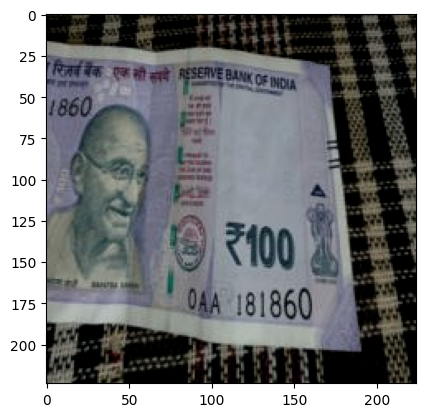

In [99]:
features, labels = next(iter(train_inputs))

print(features[0].shape)
print(len(labels))

plt.imshow(features[0])

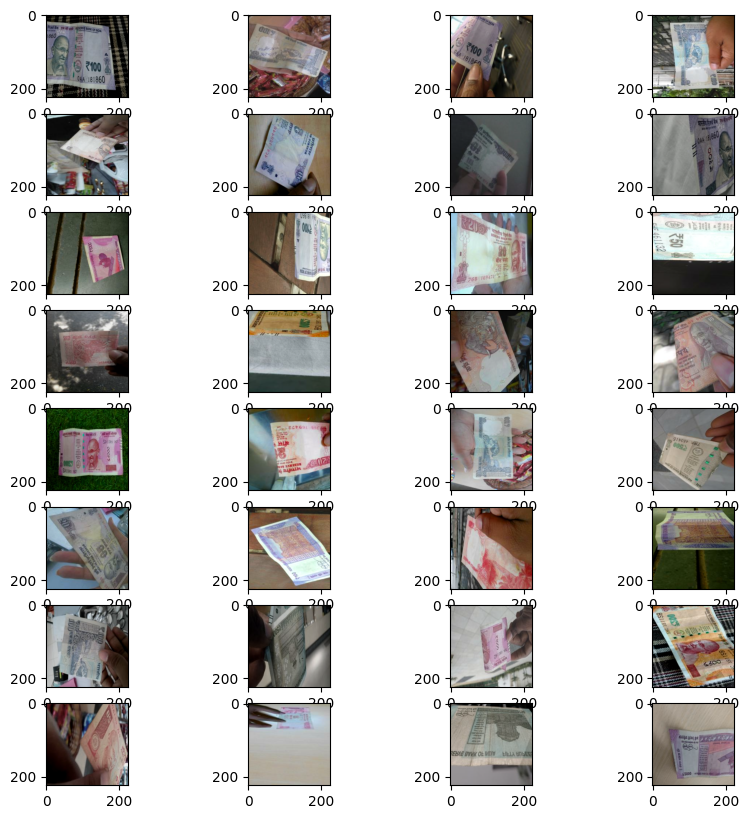

In [111]:
rows=8
cols = 4
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10,10))

for i in range(rows):
    for j in range(cols):        
        if img_count < 32:
            axes[i, j].imshow(features[img_count])
            img_count+=1

In [113]:
from tensorflow.keras import datasets, layers, models

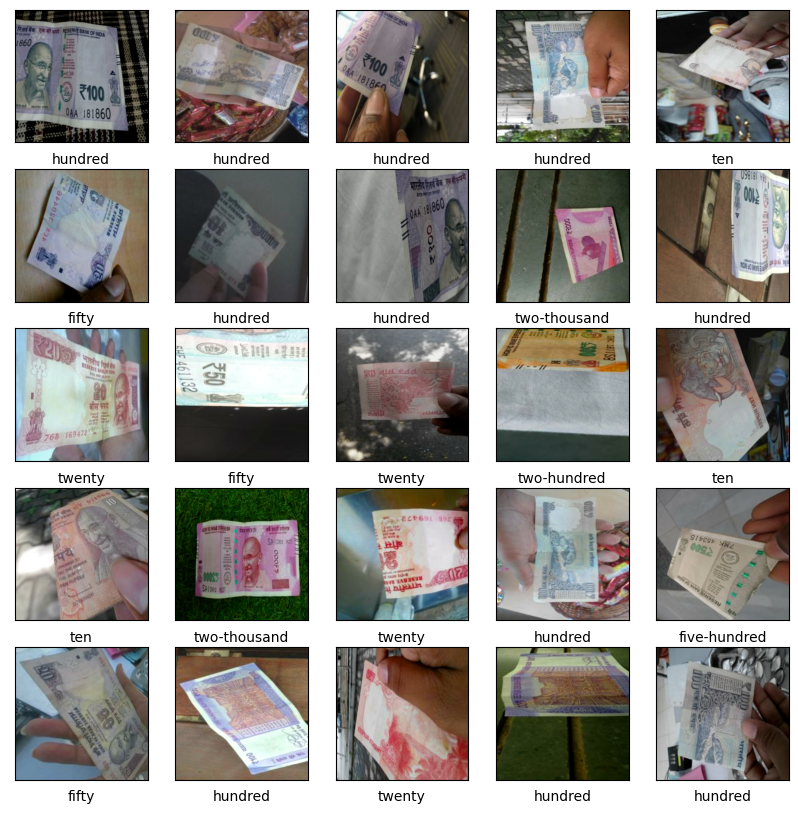

In [134]:
class_names = ['ten', 'twenty', 'fifty', 'hundred', 'two-hundred',
               'five-hundred', 'two-thousand']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(features[i])
    plt.xlabel(class_names[labels[i]])
plt.show()

In [142]:
import tensorflow as tf
import os
import time


class CNN(tf.keras.Model):
    def __init__(self, num_classes, device="cpu:0", checkpoint_directory=None, params=None):

        super(CNN, self).__init__()
        # alexnet implementation
        self.cnn1 = tf.keras.layers.Conv2D(filters=96, kernel_size=11, strides=4, activation="relu")
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.maxpool1 = tf.keras.layers.MaxPool2D(pool_size=3, strides=2)

        self.cnn2 = tf.keras.layers.Conv2D(filters=256, kernel_size=5, strides=1, activation="relu")
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.maxpool2 = tf.keras.layers.MaxPool2D(pool_size=3, strides=2)

        self.cnn3 = tf.keras.layers.Conv2D(filters=384, kernel_size=3, strides=1, activation="relu")
        self.bn3 = tf.keras.layers.BatchNormalization()

        self.cnn4 = tf.keras.layers.Conv2D(filters=384, kernel_size=3, strides=1, activation="relu")
        self.bn4 = tf.keras.layers.BatchNormalization()

        self.cnn5 = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, activation="relu")
        self.bn5 = tf.keras.layers.BatchNormalization()

        self.maxpool3 = tf.keras.layers.MaxPool2D(pool_size=3, strides=2)
        self.flatten1 = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense(4096, activation="relu")
        self.dropout1 = tf.keras.layers.Dropout(0.5)
        self.dense2 = tf.keras.layers.Dense(4096, activation="relu")
        self.dropout2 = tf.keras.layers.Dropout(0.5)
        self.classifier = tf.keras.layers.Dense(num_classes)

        self.device = device
        self.checkpoint = tf.train.Checkpoint(model=self)
        self.checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")
        self.params = params

    def predict(self, inputs, training):
        # alexnet implementation
        x = self.cnn1(inputs)
        x = self.bn1(x, training=training)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = self.bn2(x, training=training)
        x = self.maxpool2(x)
        x = self.cnn3(x)
        x = self.bn3(x, training=training)
        x = self.cnn4(x)
        x = self.bn4(x, training=training)
        x = self.cnn5(x)
        x = self.bn5(x, training=training)
        x = self.maxpool3(x)
        x = self.flatten1(x)
        x = self.dense1(x)
        x = self.dropout1(x, training=training)
        x = self.dense2(x)
        x = self.dropout2(x, training=training)
        output = self.classifier(x)

        return output

In [171]:
out_dir = os.getcwd().rsplit("/", 1)[0]
ckpt = os.path.join(out_dir, "experiments/checkpoints")

    # Define optimizer.
optimizer = tf.optimizers.Adam()

    # Instantiate model. This doesn't initialize the variables yet.
model = CNN(num_classes=params.num_labels, checkpoint_directory=ckpt, params=params)
    # compile model. This initializes the variables.
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [172]:
features, labels = next(iter(train_inputs))

In [173]:
features.shape

TensorShape([32, 224, 224, 3])

In [174]:
logits = model.predict(features,training=True)
logits,labels

(<tf.Tensor: shape=(32, 6), dtype=float32, numpy=
 array([[-8.85572672e-01, -7.53100753e-01, -3.56726944e-01,
         -7.67523944e-01,  3.44572365e-01,  6.31864786e-01],
        [-1.97950244e+00,  4.24382091e-02,  6.81399405e-01,
          1.56488311e+00,  8.73455644e-01,  9.13389087e-01],
        [-1.67160046e+00, -4.07824516e-01, -8.53696465e-02,
         -1.53609884e+00,  1.03093266e-01,  4.56569910e-01],
        [-7.92872667e-01,  5.43512046e-01, -1.06257915e-01,
         -1.20630264e-01, -3.09353739e-01,  6.40626311e-01],
        [-1.19267866e-01, -9.36296701e-01, -1.92421973e-02,
          9.33337212e-03,  2.14388996e-01, -3.85652661e-01],
        [-5.25481761e-01, -1.06915784e+00, -9.11587656e-01,
         -6.59459114e-01, -8.82064998e-02,  5.56339741e-01],
        [-6.98738098e-02, -1.26514220e+00, -2.87077218e-01,
          4.26917970e-02, -1.22335291e+00,  3.72410715e-02],
        [-1.04373348e+00, -2.26572394e-01, -1.07462823e+00,
         -1.82714403e-01,  2.20053971e-01, 

In [175]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
loss_fn(labels,op)

<tf.Tensor: shape=(), dtype=float32, numpy=2.395053>